In [2]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    log_loss,
    roc_auc_score,
    recall_score,
    precision_score,
    accuracy_score,
    plot_roc_curve,
    plot_confusion_matrix,
    roc_curve,
    confusion_matrix,
)
import itertools
from tensorflow.keras.initializers import Constant, TruncatedNormal
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from numpy import mean, absolute

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

Measurement Bias Mitigation: drop correlating features => count of tasks


In [5]:
## define count of n from temporal models
n = list(range(2, 61))

In [ ]:
## load data per matrix
for i in n:
    path = (
        "../../02_dropout_prediction/01_keep_it_up/matrices_allsessions/matrix"
        + str(i)
        + ".pkl"
    )
    infile = open(path, "rb")
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index(level=0)

    df_1 = df[df.Sex__m == 1]
    df_0 = df[df.Sex__w == 1]
    df = pd.concat([df_0, df_1])

    # save
    path = "gender_measurement/matrix" + str(i) + ".pkl"
    df.to_pickle(path)

Models

In [3]:
## define metrics dataframe
metrics = pd.DataFrame(
    columns=[
        "model",
        "group",
        "subgroup",
        "Length",
        "Sentence",
        "Accuracy",
        "Precision",
        "Recall",
        "AUC",
        "FPR",
    ]
)

In [4]:
## define feature cols
feature_cols = [
    "Erstloesung",
    "Schussel",
    "Erfolg",
    "Schwierigkeit",
    "ist_Schulzeit",
    "MehrfachFalsch",
    "vorher_abgebrochen",
    "Fehler",
    "Klassenstufe",
    "Jahredabei",
    "Sex__m",
    "Sex__w",
    "Testposition__pruefung",
    "Testposition__training",
    "Testposition__version",
    "Art__GK",
    "Art__GR",
    "Art__GZ",
    "Art__K",
    "Art__LB",
    "UserAttribut",
    "OrderNumber",
    "steps",
]

In [6]:
"""
calculate and extract relevant metrics from y and pred
return metrics
"""


def get_metrics(clf, X, y, cv, pred):
    a = accuracy_score(y, pred)
    p = precision_score(y, pred)
    r = recall_score(y, pred)
    roc_auc = roc_auc_score(y, pred)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    fpr = fp / (fp + tn)

    return a, p, r, roc_auc, fpr

Decision Tree Classifier

In [ ]:
## model fitting and validation for each subgroup

# loop through matrices
for i in n:
    path = "gender_measurement/matrix" + str(i) + ".pkl"
    infile = open(path, "rb")
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index()
    X = df[feature_cols]
    y = df.y
    y = y.astype("int")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1
    )
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    # fit
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    a, p, r, roc_auc, fpr = get_metrics(clf, X_test, y_test, cv, pred)
    metrics = metrics.append(
        {
            "model": "DTE",
            "group": "all",
            "subgroup": "all",
            "Length": len(df),
            "Sentence": i,
            "Accuracy": a,
            "Precision": p,
            "Recall": r,
            "AUC": roc_auc,
            "FPR": fpr,
        },
        ignore_index=True,
    )

    ##
    # let the model above predict for each subgroup and save results to evaluate later
    group = ["gender", "gender"]
    subgroup = ["boys", "girls"]
    matrice = ["matrices_forte_boys", "matrices_forte_girls"]

    for group, subgroup, matrix in zip(group, subgroup, matrice):
        path = (
            "../../02_dropout_prediction/01_keep_it_up/"
            + matrix
            + "/matrix"
            + str(i)
            + ".pkl"
        )
        infile = open(path, "rb")
        df = pickle.load(infile)
        infile.close()
        df = df.reset_index()
        X = df[feature_cols]
        y = df.y
        y = y.astype("int")
        pred = clf.predict(X)

        a, p, r, roc_auc, fpr = get_metrics(clf, X, y, cv, pred)
        metrics = metrics.append(
            {
                "model": "DTE",
                "group": group,
                "subgroup": subgroup,
                "Length": len(df),
                "Sentence": i,
                "Accuracy": a,
                "Precision": p,
                "Recall": r,
                "AUC": roc_auc,
                "FPR": fpr,
            },
            ignore_index=True,
        )

KNN

In [8]:
## model fitting and validation for each subgroup

# loop through matrices
for i in n:
    path = "gender_measurement/matrix" + str(i) + ".pkl"
    infile = open(path, "rb")
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index()
    X = df[feature_cols]
    y = df.y
    y = y.astype("int")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1
    )
    k = 5
    cv = KFold(n_splits=k, random_state=None)

    # fit
    knn = KNeighborsClassifier(n_neighbors=2)
    knn = knn.fit(X_train, y_train)
    pred = knn.predict(X_test)

    a, p, r, roc_auc, fpr = get_metrics(knn, X_test, y_test, cv, pred)
    metrics = metrics.append(
        {
            "model": "KNN",
            "group": "all",
            "subgroup": "all",
            "Length": len(df),
            "Sentence": i,
            "Accuracy": a,
            "Precision": p,
            "Recall": r,
            "AUC": roc_auc,
            "FPR": fpr,
        },
        ignore_index=True,
    )

    ##
    # let the model above predict for each subgroup and save results to evaluate later
    group = ["gender", "gender"]
    subgroup = ["boys", "girls"]
    matrice = ["matrices_forte_boys", "matrices_forte_girls"]

    for group, subgroup, matrix in zip(group, subgroup, matrice):
        path = (
            "../../02_dropout_prediction/01_keep_it_up/"
            + matrix
            + "/matrix"
            + str(i)
            + ".pkl"
        )
        infile = open(path, "rb")
        df = pickle.load(infile)
        infile.close()
        df = df.reset_index()
        X = df[feature_cols]
        y = df.y
        y = y.astype("int")
        pred = knn.predict(X)

        a, p, r, roc_auc, fpr = get_metrics(knn, X, y, cv, pred)
        metrics = metrics.append(
            {
                "model": "KNN",
                "group": group,
                "subgroup": subgroup,
                "Length": len(df),
                "Sentence": i,
                "Accuracy": a,
                "Precision": p,
                "Recall": r,
                "AUC": roc_auc,
                "FPR": fpr,
            },
            ignore_index=True,
        )

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\1552020202.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\1552020202.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\1552020202.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\1552020202.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\1552020202.py:65: F

MLP

In [9]:
## model fitting and validation for each subgroup

""""
build dropout prediction model
"""


def build_model():
    # create model
    model = Sequential()
    model.add(Dense(23, input_dim=23, activation="relu"))
    model.add(Dense(44, activation="relu"))
    model.add(Dense(23, activation="relu"))
    model.add(Dense(11, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    return model


"""
calculate and extract relevant metrics from y and pred
return metrics
"""


def get_dn_metrics(model, X, y):
    yhat_probs = model.predict(X, verbose=0)
    yhat_classes = (model.predict(X) > 0.5).astype("int32")
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    a = accuracy_score(y, yhat_classes)
    p = precision_score(y, yhat_classes)
    r = recall_score(y, yhat_classes)
    roc_auc = roc_auc_score(y, yhat_probs)
    tn, fp, fn, tp = confusion_matrix(y, yhat_classes).ravel()
    fpr = fp / (fp + tn)

    return a, p, r, roc_auc, fpr


# loop through matrices
for i in n:
    path = "gender_measurement/matrix" + str(i) + ".pkl"
    infile = open(path, "rb")
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index()

    y_len = len(feature_cols)
    X = df[feature_cols].astype(float)
    y = df.y
    y = y.astype("int")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1
    )

    model = build_model()

    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

    model.fit(
        x=X_train,
        y=y_train,
        epochs=10,
        batch_size=128,
        verbose=0,
        validation_data=(X_test, y_test),
    )

    scores = model.evaluate(x=X_test, y=y_test, verbose=0)

    # call function to get metrics and append metrics to df
    a, p, r, roc_auc, fpr = get_dn_metrics(model, X_test, y_test)
    metrics = metrics.append(
        {
            "model": "DL",
            "group": "all",
            "subgroup": "all",
            "Length": len(df),
            "Sentence": i,
            "Accuracy": a,
            "Precision": p,
            "Recall": r,
            "AUC": roc_auc,
            "FPR": fpr,
        },
        ignore_index=True,
    )

    ##
    # let the model above predict for each subgroup and save results to evaluate later
    group = ["gender", "gender"]
    subgroup = ["boys", "girls"]
    matrice = ["matrices_forte_boys", "matrices_forte_girls"]

    for group, subgroup, matrix in zip(group, subgroup, matrice):
        path = (
            "../../02_dropout_prediction/01_keep_it_up/"
            + matrix
            + "/matrix"
            + str(i)
            + ".pkl"
        )
        infile = open(path, "rb")
        df = pickle.load(infile)
        infile.close()
        df = df.reset_index()
        y_len = len(feature_cols)
        X = df[feature_cols].astype(float)
        y = df.y
        y = y.astype("int")

        # call function to get metrics and append to df
        a, p, r, roc_auc, fpr = get_dn_metrics(model, X, y)
        metrics = metrics.append(
            {
                "model": "DL",
                "group": group,
                "subgroup": subgroup,
                "Length": len(df),
                "Sentence": i,
                "Accuracy": a,
                "Precision": p,
                "Recall": r,
                "AUC": roc_auc,
                "FPR": fpr,
            },
            ignore_index=True,
        )

1526/1526 [==============================] - 1s 930us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


679/679 [==============================] - 1s 859us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


738/738 [==============================] - 1s 869us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1468/1468 [==============================] - 1s 862us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


670/670 [==============================] - 1s 878us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


729/729 [==============================] - 1s 855us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1427/1427 [==============================] - 1s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


664/664 [==============================] - 1s 853us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


723/723 [==============================] - 1s 834us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1391/1391 [==============================] - 1s 876us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


657/657 [==============================] - 1s 785us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


718/718 [==============================] - 1s 759us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1357/1357 [==============================] - 1s 808us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


650/650 [==============================] - 1s 844us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


713/713 [==============================] - 1s 869us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1324/1324 [==============================] - 1s 868us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


644/644 [==============================] - 1s 911us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


708/708 [==============================] - 1s 880us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1295/1295 [==============================] - 1s 886us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


639/639 [==============================] - 1s 876us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


703/703 [==============================] - 1s 838us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1265/1265 [==============================] - 1s 868us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


633/633 [==============================] - 1s 884us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


698/698 [==============================] - 1s 887us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


1235/1235 [==============================] - 1s 828us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


627/627 [==============================] - 1s 947us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


692/692 [==============================] - 1s 848us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


987/987 [==============================] - 1s 863us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


497/497 [==============================] - 0s 875us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


530/530 [==============================] - 0s 906us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


962/962 [==============================] - 1s 872us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


491/491 [==============================] - 0s 882us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


525/525 [==============================] - 0s 878us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


939/939 [==============================] - 1s 879us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


485/485 [==============================] - 0s 875us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


520/520 [==============================] - 0s 896us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


916/916 [==============================] - 1s 866us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


480/480 [==============================] - 0s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


515/515 [==============================] - 0s 864us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


745/745 [==============================] - 1s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


387/387 [==============================] - 0s 869us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


405/405 [==============================] - 0s 870us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


719/719 [==============================] - 1s 818us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


379/379 [==============================] - 0s 823us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


397/397 [==============================] - 0s 809us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


699/699 [==============================] - 1s 899us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


374/374 [==============================] - 0s 897us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


393/393 [==============================] - 0s 863us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


681/681 [==============================] - 1s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


369/369 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


389/389 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


563/563 [==============================] - 1s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


306/306 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


313/313 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


531/531 [==============================] - 1s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


293/293 [==============================] - 0s 922us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


297/297 [==============================] - 0s 912us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


515/515 [==============================] - 0s 937us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


289/289 [==============================] - 0s 940us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


292/292 [==============================] - 0s 980us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


502/502 [==============================] - 0s 912us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


286/286 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


289/289 [==============================] - 0s 899us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


425/425 [==============================] - 0s 813us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


239/239 [==============================] - 0s 842us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


239/239 [==============================] - 0s 838us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


395/395 [==============================] - 0s 937us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


224/224 [==============================] - 0s 913us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


222/222 [==============================] - 0s 954us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


381/381 [==============================] - 0s 917us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


218/218 [==============================] - 0s 965us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


216/216 [==============================] - 0s 932us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


369/369 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


215/215 [==============================] - 0s 945us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


213/213 [==============================] - 0s 940us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


320/320 [==============================] - 0s 941us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


187/187 [==============================] - 0s 957us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


182/182 [==============================] - 0s 990us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


293/293 [==============================] - 0s 910us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


171/171 [==============================] - 0s 947us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


166/166 [==============================] - 0s 979us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


279/279 [==============================] - 0s 877us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


164/164 [==============================] - 0s 963us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


160/160 [==============================] - 0s 903us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


269/269 [==============================] - 0s 903us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


160/160 [==============================] - 0s 936us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


157/157 [==============================] - 0s 946us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


241/241 [==============================] - 0s 951us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


143/143 [==============================] - 0s 992us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


138/138 [==============================] - 0s 937us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


219/219 [==============================] - 0s 916us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


132/132 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


124/124 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


206/206 [==============================] - 0s 957us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


125/125 [==============================] - 0s 966us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


118/118 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


198/198 [==============================] - 0s 977us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


121/121 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


115/115 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


181/181 [==============================] - 0s 939us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


  1/103 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


103/103 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


  1/101 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/94 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


94/94 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/95 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/88 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


88/88 [==============================] - 0s 998us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


145/145 [==============================] - 0s 957us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/84 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


84/84 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/85 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/77 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


77/77 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/79 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/72 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


72/72 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/72 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/67 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


67/67 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/68 [..............................] - ETA: 1s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/63 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


63/63 [==============================] - 0s 961us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/64 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/59 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


59/59 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/59 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/54 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


54/54 [==============================] - 0s 997us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


 1/55 [..............................] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


50/50 [==============================] - 0s 886us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


52/52 [==============================] - 0s 818us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


43/47 [==========================>...] - ETA: 0s

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


47/47 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


49/49 [==============================] - 0s 984us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


43/43 [==============================] - 0s 1000us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


45/45 [==============================] - 0s 909us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


40/40 [==============================] - 0s 953us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


42/42 [==============================] - 0s 961us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


37/37 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


39/39 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


34/34 [==============================] - 0s 806us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


36/36 [==============================] - 0s 977us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


32/32 [==============================] - 0s 947us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


34/34 [==============================] - 0s 943us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


29/29 [==============================] - 0s 857us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


31/31 [==============================] - 0s 928us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


27/27 [==============================] - 0s 918us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


29/29 [==============================] - 0s 801us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


26/26 [==============================] - 0s 861us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


27/27 [==============================] - 0s 946us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


24/24 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


26/26 [==============================] - 0s 977us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


23/23 [==============================] - 0s 822us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


24/24 [==============================] - 0s 908us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


21/21 [==============================] - 0s 960us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


22/22 [==============================] - 0s 1ms/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


19/19 [==============================] - 0s 842us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


20/20 [==============================] - 0s 917us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


18/18 [==============================] - 0s 925us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


19/19 [==============================] - 0s 999us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


16/16 [==============================] - 0s 935us/step


C:\Users\Nathalie\AppData\Local\Temp\ipykernel_13344\3469876962.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(


In [10]:
## construct dfs for all groups from metric df
grouped = metrics.groupby(metrics.group)
df_all = grouped.get_group("all")
modell = df_all.groupby(df_all.model)
dte = modell.get_group("DTE")
knn = modell.get_group("KNN")
dl = modell.get_group("DL")

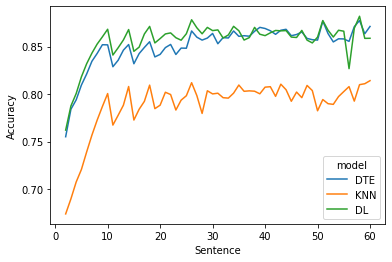

In [25]:
## plot accuracy by n and model
ax = sns.lineplot(data=df_all, x="Sentence", y="Accuracy", hue="model")

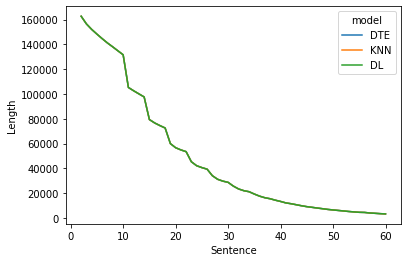

In [26]:
## plot count of sentences by n and model
ax = sns.lineplot(data=df_all, x="Sentence", y="Length", hue="model")

Evaluate

In [13]:
metrics

,model,group,subgroup,Length,Sentence,Accuracy,Precision,Recall,AUC,FPR
0,DTE,all,all,162729,2,0.755075,0.753292,0.867315,0.731193,0.404929
1,DTE,gender,boys,21725,2,0.806214,0.927061,0.835818,0.74168,0.352459
2,DTE,gender,girls,23603,2,0.830869,0.938836,0.863489,0.730466,0.402557
3,DTE,all,all,156555,3,0.784019,0.781639,0.89915,0.750203,0.398744
4,DTE,gender,boys,21422,3,0.834096,0.940014,0.860695,0.769496,0.321703
...,...,...,...,...,...,...,...,...,...,...
526,DL,gender,boys,640,59,0.909375,0.973776,0.928333,0.88225,0.375
527,DL,gender,girls,552,59,0.913043,0.974257,0.933586,0.865503,0.52
528,DL,all,all,3209,60,0.858775,0.906372,0.9159,0.896137,0.356436
529,DL,gender,boys,597,60,0.887772,0.980469,0.898032,0.915639,0.263158


In [28]:
grouped = metrics.groupby(metrics.group)
df_gender = grouped.get_group("gender")

# calculate fairness metrics
df_gender = df_gender.drop(columns=["group", "Accuracy"])
df_gender = pd.pivot_table(
    df_gender,
    values=["Precision", "Recall", "AUC", "FPR"],
    index=["model", "Sentence"],
    columns=["subgroup"],
)
df_gender["PP"] = df_gender.Precision.girls - df_gender.Precision.boys
df_gender["EO"] = df_gender.Recall.boys - df_gender.Recall.girls
df_gender["SA"] = df_gender.AUC.girls - df_gender.AUC.boys
df_gender["PE"] = df_gender.FPR.boys - df_gender.FPR.girls
df_gender = df_gender.drop(columns=["AUC", "Precision", "Recall", "FPR"])
df_gender.columns = df_gender.columns.droplevel(1)
df_gender = pd.pivot_table(
    df_gender, values=["PP", "EO", "SA", "PE"], index=["Sentence"], columns=["model"]
)

In [24]:
df_gender.to_pickle('df_gender_220223')

In [15]:
"""
functions to format results
set two threshols: one at |0.02| in orange and one at |0.05| in red
format all negative values in bold
"""


def threshold001(v, props=""):
    return props if (v > 0.02) or (v < -0.02) else None


def threshold005(v, props=""):
    return props if (v > 0.05) or (v < -0.05) else None


def negativeValue(v, props=""):
    return props if (v < 0) else None


def showTable(df):
    styled = (
        df.style.set_properties(color="black", align="right")
        .set_properties(**{"background-color": "white"})
        .applymap(threshold001, props="color:orange;")
        .applymap(threshold005, props="color:red;")
        .applymap(negativeValue, props="font-weight:bold;")
    )
    return styled

In [19]:
test = df_gender
met = ['EO','PE','PP','SA']
fertig = pd.DataFrame()
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DL[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DL[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DL[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])
    
    d = 0
    for i in range(30, 40):
        d = d+test[x].DL[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DL[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DL[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DL',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].DTE[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].DTE[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].DTE[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].DTE[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].DTE[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].DTE[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'DTE',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])
met = ['EO','PE','PP','SA']
for x in met:        
    a = 0
    for i in range(2, 10):
        a = a+test[x].KNN[i]
    a = a/8
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '02-9',
            'Val': a
        }
    )
    fertig = pd.concat([fertig, temp])

    b = 0
    for i in range(10, 20):
        b = b+test[x].KNN[i]
    b = b/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '10-19',
            'Val': b
        }
    )
    fertig = pd.concat([fertig, temp])

    c = 0
    for i in range(20, 30):
        c = c+test[x].KNN[i]
    c = c/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '20-29',
            'Val': c
        }
    )
    fertig = pd.concat([fertig, temp])

    d = 0
    for i in range(30, 40):
        d = d+test[x].KNN[i]
    d = d/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '30-39',
            'Val': d
        }
    )
    fertig = pd.concat([fertig, temp])

    e = 0
    for i in range(40, 50):
        e = e+test[x].KNN[i]
    e = e/9
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '40-49',
            'Val': e
        }
    )
    fertig = pd.concat([fertig, temp])

    f = 0
    for i in range(50, 60):
        f = f+test[x].KNN[i]
    f = f/10
    temp = pd.DataFrame(
        {
            'Metrik':[x],
            'Model': 'KNN',
            'Range': '50-60',
            'Val': f
        }
    )
    fertig = pd.concat([fertig, temp])

In [20]:
mean_table = pd.pivot_table(fertig, values=['Val'], index=['Range'], columns=['Metrik','Model'])
showTable(mean_table)

In [32]:
## create a table that is readable
# take the mean from ten sentences as one cell

met = ["EO", "PE", "PP", "SA"]
model = ["DL", "DTE", "KNN"]
ranges = [
    ("02-9", 8, 2, 10),
    ("10-19", 9, 10, 20),
    ("20-29", 9, 20, 30),
    ("30-39", 9, 30, 40),
    ("40-49", 9, 40, 50),
    ("50-60", 10, 50, 60),
]

frame_means = pd.DataFrame()

# for each metric
for m in met:
    for mo in model:
        for r, div, begin, end in ranges:
            s = 0
            for i in range(begin, end):
                s += df_gender[m][mo][i]
            temp = pd.DataFrame(
                {"Metrik": [m], "Model": mo, "Range": r, "Val": s / div}
            )
            frame_means = pd.concat([frame_means, temp])

# pivot table
mean_table = pd.pivot_table(
    frame_means, values=["Val"], index=["Range"], columns=["Metrik", "Model"]
)
#showTable(mean_table)

In [33]:
showTable(mean_table)

In [ ]:
# s = showTable(df_gender)
# s

In [21]:
# save
writer = pd.ExcelWriter("df_gender_noAnzahlAufg.xlsx", engine="xlsxwriter")
mean_table.to_excel(writer, sheet_name="Gender")
writer.save()